### Although mAP metric is popular, I think we still need to write a new notebook to compute CV score
1. Most of the mAP calculators are integrated within particular frameworks such as detectron2, yolo, mmdet, etc... It might lack flexibility if we want to ensemble various models.
2. Some standalone codes only compute box-mAP, not segm-mAP

=> So I reimplement the code to compute mAP for this competition. **Note that it only support single class at the moment**. I use my Detectron2 model to make predictions as an example and I also compare with Detectron2 built-in CocoEvaluator

In [339]:
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt

In [340]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib
import json
import torch

In [341]:
class CFG:
    
    MODEL_PATH = "/home/viktor/Documents/kaggle/hubmap-2023/experiments/mvp-segformer-norm2/ckpts/segformer_epoch_74.pt"
    THRESHOLD = 0.8
    IMG_DIR = "/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train"
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [342]:
from transformers import SegformerForSemanticSegmentation
import torch    
import torch.nn as nn

class Segformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=1,
                                                         ignore_mismatched_sizes=True,
                                                         num_channels=3)
        self.up = nn.Upsample(scale_factor=4, mode="bilinear")
        
    def forward(self, x):
        x = self.seg_model(x).logits
        x = self.up(x)
        return x



model = Segformer()


state_dict = torch.load(CFG.MODEL_PATH)
model.load_state_dict(state_dict)
model = model.to(CFG.device)


model = model.to(CFG.device)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.classifier.bias', 'decode_head.batch_nor

In [343]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

def preprocess_img_for_model_inference(img_path):
    # image = cv2.imread(img_path)
    image = Image.open(img_path)
    
    image = np.array(image)
    
    
    # apply 
    aug_list = [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
   # Create the augmentation pipeline
    augmentations = A.Compose(aug_list)
    
    
    # image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    image = augmentations(image=image)["image"].unsqueeze(0)
    
    
    mean = torch.mean(image, dim=[1,2])
    std = torch.std(image, dim=[1,2])
    
    image = (image - mean[:, None, None]) / std[:, None, None]
    
    return image    

In [344]:
def seg_to_det(
    seg: np.ndarray, 
):
    num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats(seg)
    boxes = stats[:, [cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT]]
    label_masks = [labels == i for i in range(num_outputs)]
    dets = {
        "boxes": np.stack([
            boxes[:, 0],
            boxes[:, 1],
            boxes[:, 0] + boxes[:, 2],
            boxes[:, 1] + boxes[:, 3],
        ], axis=1),
        "masks": [seg * m for m in label_masks],
    }
    dets["scores"] = [np.max(seg[m]) for m in label_masks]
    
    # remove dets element where 'boxes' = [0, 0, 512, 512]
    boxes_to_remove = [0, 0, 512, 512]
    indices_to_remove = np.where(np.all(dets["boxes"] == boxes_to_remove, axis=1))
    
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    
    # remove dets where np.sum(mask) < 300
    indices_to_remove = []
    for i, mask in enumerate(dets["masks"]):
        if np.sum(mask) < 300:
            indices_to_remove.append(i)
            
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    return dets

def predict(img_path):
    image = preprocess_img_for_model_inference(img_path)
    image = image.to(CFG.device)
    with torch.no_grad():
        pred = model(image)
        pred = torch.sigmoid(pred)
        pred = pred.squeeze().cpu().numpy()
    
    
    pred = (pred > CFG.THRESHOLD).astype(np.uint8)*255
    dets = seg_to_det(pred)
    pred_masks, pred_classes, scores = dets["masks"], [0]*len(dets["masks"]), dets["scores"]
    
    # convert pred_masks to uint8_t
    pred_masks = [m.astype(np.uint8) for m in pred_masks]
    
    return pred_masks, pred_classes, scores

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


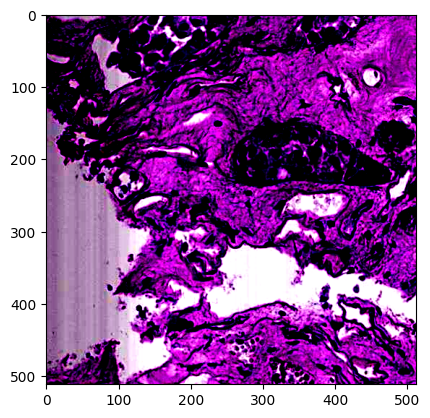

In [345]:
import numpy as np

x = preprocess_img_for_model_inference('/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/test/72e40acccadf.tif')

# visualize
plt.imshow(x.squeeze().permute(1, 2, 0).cpu().numpy())

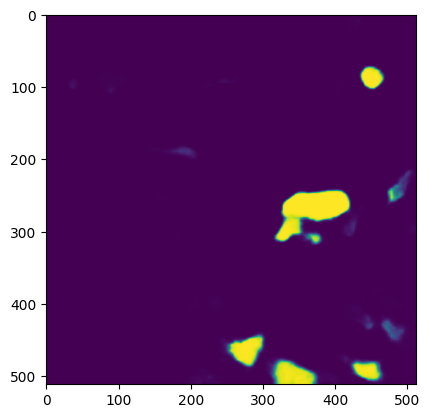

In [346]:
image = preprocess_img_for_model_inference('/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/test/72e40acccadf.tif')


image = image.to(CFG.device)

with torch.no_grad():
    pred = model(image)
    pred = torch.sigmoid(pred)
    pred = pred.squeeze().cpu().numpy()
    
    

plt.imshow(pred)

In [347]:
num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats((pred>0.5).astype(np.uint8)*255)

In [348]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [349]:
pred_masks, pred_classes, scores = predict('/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/test/72e40acccadf.tif')

In [350]:
pred_masks[0].min()

0

In [351]:
[m.sum() for m in pred_masks]

[195840, 94095, 1053660, 57120, 61200, 1020, 370515, 405195, 226695]

In [352]:
len(pred_masks)

9

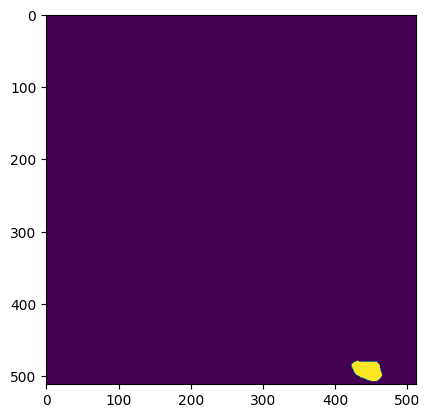

In [353]:
# find number of elements in pred_masks[0] where value is between 0.4 and 0.6
plt.imshow(pred_masks[-1])

In [354]:
img_path = '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/test/72e40acccadf.tif'
pred_masks, pred_classes, scores = predict(img_path)


## segm-mAP code

In [355]:
import pycocotools.mask as mask_util

In [356]:
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


In [357]:
class MAPCalculatorSingleClass:
    def __init__(self, thresholds=[0.6]):
        self.ious = []
        self.confidences = []
        self.image_ids = []
        self.current_img_id = 0
        
        self.GT = 0
        
    def accumulate(self, ious, confidences, num_gt):
        assert len(ious) == len(confidences)
        self.ious.extend([x for x in ious])
        self.confidences.extend(confidences)
        self.image_ids.extend([self.current_img_id]*len(confidences))
        self.current_img_id += 1
        self.GT += num_gt
        
        
    def evaluate(self, thresholds=[0.6], vis=False):        
        # sort by confidence descending
        sorted_inds = np.argsort(self.confidences)[::-1]
        
        results = dict()
        
        for th in thresholds:
            accum_tp = 0
            accum_fp = 0
            
            TP = []
            FP = []
            list_gts = dict()
            
            NPREDS = []
            count = 0
            for ind in sorted_inds:
                iou_row = self.ious[ind]
                img_id = self.image_ids[ind]
                
                matched_inds = np.where(iou_row >= th)[0]
                best_gt_ind = -1
                best_iou = 0
                for gt_ind in matched_inds:
                    iou = iou_row[gt_ind]
                    if iou > best_iou and list_gts.get((img_id, gt_ind)) is None:
                        best_iou = iou
                        best_gt_ind = gt_ind
                
                if best_gt_ind != -1:
                    list_gts[(img_id, best_gt_ind)] = True
                    accum_tp += 1
                else:
                    accum_fp += 1
                    
                count += 1
                NPREDS.append(count)
                    
                TP.append(accum_tp)
                FP.append(accum_fp)
                
            PR = []
            REC = []
            
            for tp, fp in zip(TP, FP):
                pr = tp / (tp+fp)
                rec = tp / self.GT
                PR.append(pr)
                REC.append(rec)
                
            if vis:
                plt.figure()
                plt.plot(REC, PR, '-o', label='precision-recall curve')
                
            ap, mrec, mpre = voc_ap(REC, PR)
            
            if vis:
                plt.plot(mrec, mpre, '--', label='interpolation')
                plt.legend()
                plt.title('Precision recall curve at threshold:'+str(np.round(th, 2)))
                plt.show()
            
            results[th] = ap
    
        return np.mean(list(results.values())), results

## Compare with Detectron2 mAP@0.5:0.95 CocoEvaluator

In [358]:
JSON_ANN = '/home/viktor/Documents/kaggle/hubmap-2023/hubmap-json/ds2_wsi1.json'
with open(JSON_ANN, 'r') as f:
    annotations = json.load(f)

In [359]:
annotations['categories'] # in json annotations, class id starts from 1

[{'id': 1, 'name': 'blood_vessel '}, {'id': 2, 'name': 'glomerulus'}]

In [360]:
JSON_BLOOD_VESSEL_CLS = 1

In [361]:
len(annotations['images'])

237

### Our custom code

In [362]:
mAP_calc = MAPCalculatorSingleClass()

for img_meta in tqdm(annotations['images'], total=len(annotations['images'])):
    
    width, height = img_meta['width'], img_meta['height']
    img_path = os.path.join(CFG.IMG_DIR, img_meta['file_name'])
    img = cv2.imread(img_path)
    
    # when calculating IOU using pycocotools.mask, we need to encode both
    # groundtruth and prediction
    
    # make ground truth    
    targs = []
    enc_targs = []
    for ann in annotations['annotations']:
        if ann['image_id'] == img_meta['id'] and ann['category_id'] == JSON_BLOOD_VESSEL_CLS:
            seg = ann['segmentation']
            if type(seg) == list: # if polygon, need to convert to RLE
                seg = coco_mask.frPyObjects(seg, height, width)[0]
            targs.append(seg)
        enc_targs = targs
    num_gts = len(enc_targs)
        
    # make prediction
    # pred_masks, pred_classes, scores = predict(predictor, img)
    pred_masks, pred_classes, scores = predict(img_path)
    
    # pred_masks: list of numpy array shape H*W 
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    
    # calculate iou
    if len(enc_targs) > 0:
        ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    else:
        ious = np.array([[0]]*len(enc_preds))
    
    
    
    # acummulate predictions
    mAP_calc.accumulate(ious, scores, num_gts)
    

  0%|          | 0/237 [00:00<?, ?it/s]

In [363]:
mAP, detail_scores = mAP_calc.evaluate(thresholds=np.arange(0.5, 1.0, 0.05))
print('segm-mAP@0.5:0.95 by custom code:', mAP)

segm-mAP@0.5:0.95 by custom code: 0.11093096485790026


## Competition metric
- In this competition, the metric is segm-mAP@0.6

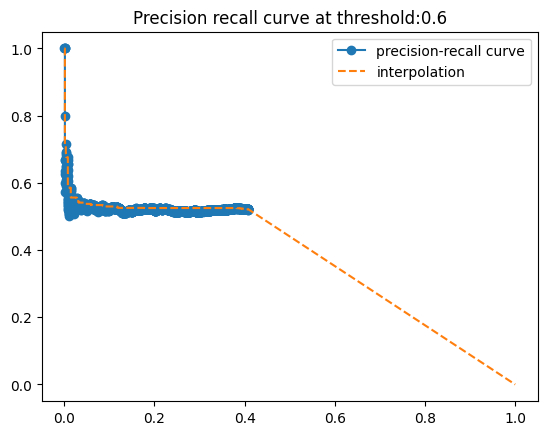

CV (mAP@0.6): 0.21792361377051217


In [364]:
# We test on the above dataset and get the CV score and visualize precision-recall curve
mAP, detail_scores = mAP_calc.evaluate(thresholds=[0.6], vis=True)
print('CV (mAP@0.6):', mAP)

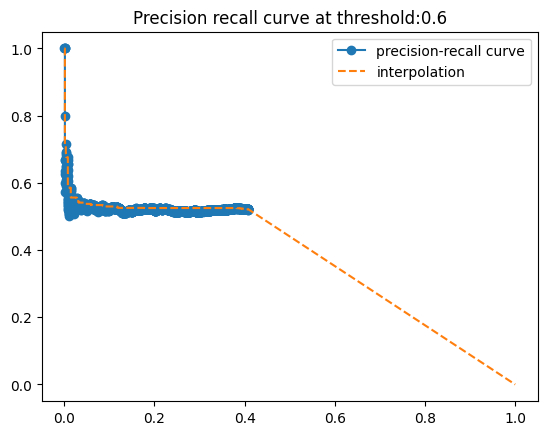

CV (mAP@0.6): 0.21792361377051217


In [365]:

# We test on the above dataset and get the CV score and visualize precision-recall curve
mAP, detail_scores = mAP_calc.evaluate(thresholds=[0.6], vis=True)
print('CV (mAP@0.6):', mAP)

## Make submission 

In [50]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [51]:
test_path = "/kaggle/input/hubmap-hacking-the-human-vasculature/test"
sample_submission = pd.read_csv('/kaggle/input/hubmap-hacking-the-human-vasculature/sample_submission.csv')
ids = []
heights = []
widths = []
prediction_strings = []


for test_name in tqdm(os.listdir(test_path)):
    inp_path = os.path.join(test_path, test_name)
    img = cv2.imread(inp_path)
    h, w, _ = img.shape
    
    pred_masks, pred_classes, scores = predict(predictor, img)
    
   
    pred_string = ""
    for i, mask in enumerate(pred_masks):
        encoded = encode_binary_mask(mask)
        
        if i == 0:
            pred_string += f"{int(pred_classes[i])} {scores[i]} {encoded.decode('utf-8')}"
        else:
            pred_string += f" {int(pred_classes[i])} {scores[i]} {encoded.decode('utf-8')}"
            
    ids.append(test_name.split('.')[0])
    heights.append(h)
    widths.append(w)
    prediction_strings.append(pred_string)
    
#     break


KeyboardInterrupt



In [ ]:
sub = pd.DataFrame({'id':ids, 'height':heights, 'width':widths, 
                    'prediction_string':prediction_strings})

In [ ]:
sub

,id,height,width,prediction_string
0,72e40acccadf,512,512,0 0.9997168183326721 eNoLjs82STCItzfxMfE19DPyB...


In [ ]:
sub.to_csv('submission.csv', index=False)